1. Generate 50 2D-data points using the following function: $y = 0.4345x^3 - 5.607x^2 + 16.78x - 10.61$

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_triangular
import time

def actual_distribution():
    x = np.arange(0, 9, 9/100);
    y = 0.4345*np.power(x,3) - 5.607*np.power(x,2) + 16.78*x - 10.61
    return x, y

2. Add Gaussian random noise to the data. 

In [5]:
def add_noise(y_curve, sigma):
    mu = 0
    noise = np.random.normal(mu, sigma, len(y_curve))
    y_noise = y_curve + noise
    return y_noise

3. Prepare the input matrix $A$ and vector $b$

In [6]:
# setup X matrix
def get_input_matrix(x_value, N, M):
    A = np.empty([0, N])

    # get the input X matrix
    for m in range(M):
        result_array = np.array([np.power(x, m)])
        A = np.append(A, result_array, axis = 0)
        
    A = np.transpose(A)
    return A

N = 100 # number of input data
M = 4 # degree of polynomial

x, y = actual_distribution() 
A = get_input_matrix(x, N, M)

# get the vector b
b = add_noise(y, sigma = 4.0)

4. Define Cholesky factorization function and qr factorization using gram-schmidt process 

In [13]:
def cholesky(A):
    n = len(A)

    # Create zero matrix for L
    L = [[0.0] * n for i in range(n)]

    # Perform the Cholesky decomposition
    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): # Diagonal elements
                L[i][k] = np.sqrt(A[i][i] - tmp_sum)
            else:
                L[i][k] = (1.0 / L[k][k] * (A[i][k] - tmp_sum))
    return np.asarray(L)

def gram_schmidt(X):
    O = np.zeros(X.shape)
    for i in range(X.shape[1]):
        # orthogonalization
        vector = X[:, i]
        space = O[:, :i]
        projection = vector @ space
        vector = vector - np.sum(projection * space, axis=1)
        # normalization
        norm = np.sqrt(vector @ vector)
        vector /= abs(norm) < 1e-8 and 1 or norm
        
        O[:, i] = vector
    return O

5. Get solutions using Cholesky and QR factorization. Time their runtime.

In [15]:
A_new = A.T.dot(A) 
b_new = A.T.dot(b)

start_time_ch = time.time() # time execution of cholesky factorization for ls problem
R = cholesky(A_new) # cholesky function 
c = solve_triangular(R, b_new, lower=True) # solve lower triangular system
x_w = solve_triangular(R.T, c, lower=False)# solve upper triangular system
total_time_ch = time.time() - start_time_ch

start_time_qr = time.time() # time execution of qr factorization for ls problem
Q = gram_schmidt(A) # gram-schmidt function to get Q
R_new = Q.T.dot(A) # get R
x_w_qr = solve_triangular(R_new, Q.T.dot(b), lower=False)# solve upper triangular system
total_time_qr = time.time() - start_time_qr

print("Weights for polynomial using Cholesky:")
print(x_w) # result weights for polynomial using Cholesky
print("Weights for polynomial using QR:")
print(x_w_qr) # result weights for polynomial using QR
print("Cholesky factorization takes %s seconds" % total_time_ch)
print("QR factorization takes %s seconds" % total_time_qr)

Weights for polynomial using Cholesky:
[-6.92990267 14.81885125 -5.30338752  0.42017253]
Weights for polynomial using QR:
[-6.92990267 14.81885125 -5.30338752  0.42017253]
Cholesky factorization takes 0.00044798851013183594 seconds
QR factorization takes 0.004197835922241211 seconds


6. Show the original curve line (red line), the noisy data, and the curve line estimated from the noisy data using Cholesky factorization (blue line) and using QR factorization (green line)

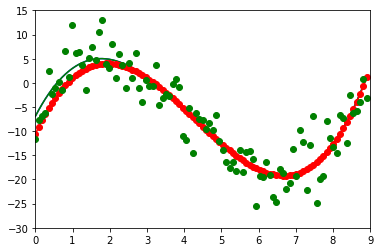

In [17]:
def get_y_estimated(w):
    p = np.poly1d(np.flip(w))
    y_estimated = p(x)
    return y_estimated

y_estimated = get_y_estimated(x_w)
y_estimated_qr = get_y_estimated(x_w_qr)

# construct the polynomial function
def plot_ploy(x, y, y_estimated, y_estimated_qr, b, x_w, x_begin, x_end, y_begin, y_end):
    plt.plot(x, y_estimated, color = 'b')
    plt.plot(x, y_estimated_qr, color = 'g')
    plt.plot(x, y, color = 'r')
    plt.plot(x, y, 'ro')
    plt.plot(x, b, 'go')
    plt.axis([x_begin, x_end, y_begin, y_end])
    plt.show()
    
plot_ploy(x, y, y_estimated, y_estimated_qr, b, x_w, 0, 9, -30, 15)